<a href="https://colab.research.google.com/github/Priesemann-Group/covid19_inference_forecast/blob/cleaning_code/example_script_covid19_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference_forecast.git@cleaning_code

  Cloning https://github.com/Priesemann-Group/covid19_inference_forecast.git (to revision cleaning_code) to /tmp/pip-req-build-ns0px21d
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference_forecast.git /tmp/pip-req-build-ns0px21d
  Running command git checkout -b cleaning_code --track origin/cleaning_code
  Switched to a new branch 'cleaning_code'
  Branch 'cleaning_code' set up to track remote branch 'cleaning_code' from 'origin'.
  Created wheel for covid19-inference: filename=covid19_inference-0.0.2-cp36-none-any.whl size=7840 sha256=2475a3bcf9f72bb79d7982bade674d964ca9d8dff6a988f52c5d72e53e8ceda1
  Stored in directory: /tmp/pip-ephem-wheel-cache-gr35rmjl/wheels/0b/b2/1d/7bff72ae35855db34fab454bb6b6cbce5566675e123ec2f41e
Successfully built covid19-inference


In [2]:
import sys
import datetime

import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt


import covid19_inference as cov19

confirmed_cases = cov19.get_jhu_confirmed_cases()

country = 'Germany'
date_data_begin = datetime.datetime(2020,3,1)
date_data_end   = cov19.get_last_date(confirmed_cases)

#date_data_end   = datetime.datetime(2020,3,28)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 28
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days


cases_obs = cov19.filter_one_country(confirmed_cases, country,
                                     date_data_begin, date_data_end)

change_points = [dict(prior_mean_date_begin_transient = datetime.datetime(2020,3,9),
                      prior_median_λ = 0.2),
                 dict(prior_mean_date_begin_transient = datetime.datetime(2020,3,16),
                      prior_sigma_date_begin_transient = 1,
                      prior_median_λ = 1/8,
                      prior_sigma_λ = 0.2),
                 dict(prior_mean_date_begin_transient = datetime.datetime(2020,3,23),
                      prior_sigma_date_begin_transient = 1,
                      prior_median_λ = 1/8/2,
                      prior_sigma_λ = 0.2)]

model = cov19.SIR_model_with_change_points(np.diff(cases_obs),
                                                       change_points,
                                                       date_begin_sim,
                                                       num_days_sim,
                                                       diff_data_sim)

trace = pm.sample(model=model, init='advi')


Set prior_beta_I_begin to default value 100
Set prior_median_λ_0 to default value 0.4
Set prior_sigma_λ_0 to default value 0.5
Set prior_median_μ to default value 0.125
Set prior_sigma_μ to default value 0.2
Set prior_median_delay to default value 8
Set prior_sigma_delay to default value 0.2
Set prior_beta_σ_obs to default value 10
Set prior_sigma_λ of change point 0 to default value 0.5
Set prior_sigma_date_begin_transient of change point 0 to default value 3
Set prior_median_transient_len of change point 0 to default value 3
Set prior_median_transient_len of change point 1 to default value 3
Set prior_median_transient_len of change point 2 to default value 3
Set prior_sigma_transient_len of change point 0 to default value 0.3
Set prior_sigma_transient_len of change point 1 to default value 0.3
Set prior_sigma_transient_len of change point 2 to default value 0.3


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 307.66:   7%|▋         | 13969/200000 [00:46<10:19, 300.08it/s]
Convergence achieved at 14000
Interrupted at 13,999 [6%]: Average Loss = 391.87
Sequential sampling (2 chains in 1 job)
NUTS: [σ_obs, delay, μ, transient_len_2, transient_len_1, transient_len_0, transient_begin_2, transient_begin_1, transient_begin_0, λ_3, λ_2, λ_1, λ_0, I_begin]
100%|██████████| 800/800 [03:12<00:00,  4.16it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


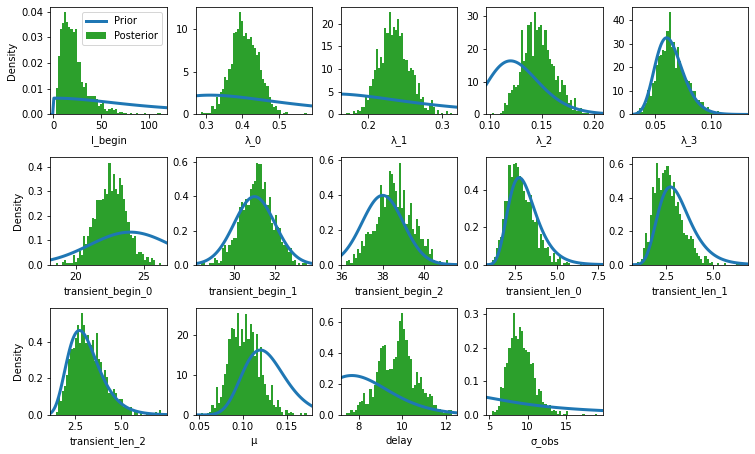

In [5]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)

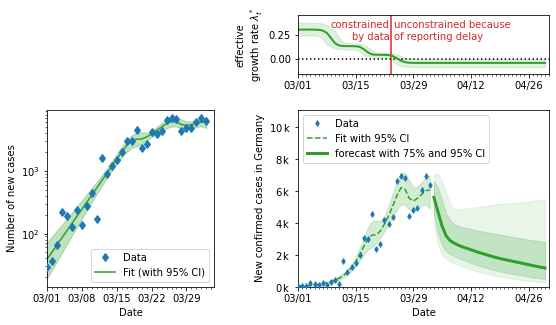

In [7]:
fig, axes = cov19.plotting.plot_cases(trace, np.diff(cases_obs), date_begin_sim, diff_data_sim,
                                      colors=('tab:blue', 'tab:green')) 